In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img

from datetime import datetime, timedelta

import platform
 
print(platform.python_version())

import keras
keras.backend.backend()

Using TensorFlow backend.


3.6.5


'tensorflow'

In [2]:
train_dir = 'img/train'
validation_dir = 'img/validation'
image_size = 224

## Experiment 1: Freezing all layers - Same as Transfer Learning
Create the model

In [3]:
from keras.applications import Xception
xception_conv = Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in xception_conv.layers[:]:
    layer.trainable = False
    
# Check the trainable status of the individual layers
for layer in xception_conv.layers:
    print(layer, layer.trainable)

pretrained_conv = xception_conv

<keras.engine.input_layer.InputLayer object at 0x12c050438> False
<keras.layers.convolutional.Conv2D object at 0x12c050748> False
<keras.layers.normalization.BatchNormalization object at 0x12c050710> False
<keras.layers.core.Activation object at 0x12c050898> False
<keras.layers.convolutional.Conv2D object at 0x12c050f98> False
<keras.layers.normalization.BatchNormalization object at 0x12c0f6f60> False
<keras.layers.core.Activation object at 0x12c0f6e10> False
<keras.layers.convolutional.SeparableConv2D object at 0x12c21eb38> False
<keras.layers.normalization.BatchNormalization object at 0x12c2cc9b0> False
<keras.layers.core.Activation object at 0x12c37ce10> False
<keras.layers.convolutional.SeparableConv2D object at 0x12c3cc2e8> False
<keras.layers.normalization.BatchNormalization object at 0x12c3eefd0> False
<keras.layers.convolutional.Conv2D object at 0x12c1815c0> False
<keras.layers.pooling.MaxPooling2D object at 0x12c495e48> False
<keras.layers.normalization.BatchNormalization obje

In [9]:
from keras.applications import VGG16

#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

pretrained_conv = vgg_conv

<keras.engine.input_layer.InputLayer object at 0x13245b0b8> False
<keras.layers.convolutional.Conv2D object at 0x111762ac8> False
<keras.layers.convolutional.Conv2D object at 0x13245bc18> False
<keras.layers.pooling.MaxPooling2D object at 0x12f498d68> False
<keras.layers.convolutional.Conv2D object at 0x12f1faac8> False
<keras.layers.convolutional.Conv2D object at 0x12f21f0b8> False
<keras.layers.pooling.MaxPooling2D object at 0x1116d57b8> False
<keras.layers.convolutional.Conv2D object at 0x1116d5630> False
<keras.layers.convolutional.Conv2D object at 0x11170e2e8> False
<keras.layers.convolutional.Conv2D object at 0x1118af198> False
<keras.layers.pooling.MaxPooling2D object at 0x1118cc7b8> False
<keras.layers.convolutional.Conv2D object at 0x1118cc630> False
<keras.layers.convolutional.Conv2D object at 0x12eee42e8> False
<keras.layers.convolutional.Conv2D object at 0x12ef03198> False
<keras.layers.pooling.MaxPooling2D object at 0x12ef1f7b8> False
<keras.layers.convolutional.Conv2D obj

In [10]:
from keras import models
from keras import layers
from keras import optimizers

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(pretrained_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2050      
Total params: 40,407,874
Trainable params: 25,693,186
Non-trainable params: 14,714,688
_________________________________________________________________


## Experiment 1
Train the model

In [11]:
# No Data augmentation 
from keras.preprocessing.image import ImageDataGenerator, load_img
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 10
val_batchsize = 10

# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

from keras.callbacks import ModelCheckpoint  
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.hdf5', 
                               verbose=1, save_best_only=True)

time1 = datetime.now()
# Train the Model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=3,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1, callbacks=[checkpointer])

time2 = datetime.now()
elapsedTime = time2 - time1
print("Elapsed time: "+ str(elapsedTime.total_seconds()) + " secs")


# Save the Model
model.save('all_freezed.h5')

# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


Found 1140 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Epoch 1/3
114/114 [==============================] - 826s 7s/step - loss: 0.5577 - acc: 0.8325 - val_loss: 0.2252 - val_acc: 0.8933

Epoch 00001: val_loss improved from inf to 0.22523, saving model to saved_models/weights.best.hdf5
Epoch 2/3
114/114 [==============================] - 745s 7s/step - loss: 0.1698 - acc: 0.9404 - val_loss: 0.0996 - val_acc: 0.9667

Epoch 00002: val_loss improved from 0.22523 to 0.09962, saving model to saved_models/weights.best.hdf5
Epoch 3/3
114/114 [==============================] - 771s 7s/step - loss: 0.1240 - acc: 0.9553 - val_loss: 0.1589 - val_acc: 0.9567

Epoch 00003: val_loss did not improve from 0.09962
Elapsed time: 2344.725993 secs


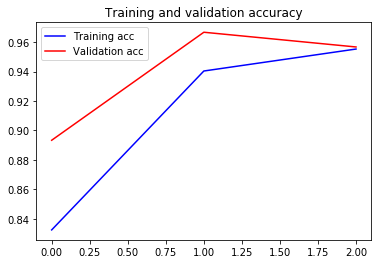

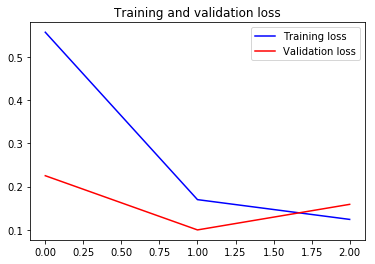

In [12]:

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Experiment 1
Show the errors

In [13]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Get the filenames from the generator
fnames = validation_generator.filenames

# Get the ground truth from generator
ground_truth = validation_generator.classes

# Get the label to class mapping from the generator
label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())


time1 = datetime.now()
# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

time2 = datetime.now()
elapsedTime = time2 - time1
print("Elapsed time: "+ str(elapsedTime.total_seconds()) + " secs")

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

Found 300 images belonging to 2 classes.
30/30 [==============================] - 171s 6s/step
Elapsed time: 170.68683 secs
No of errors = 13/300


In [15]:

print("accuracy: " + str((validation_generator.samples-len(errors))/validation_generator.samples*100)+" %")

accuracy: 95.66666666666667 %
